# **Homework 15 - Reinforcement Learning**
這裡是 report 第一題，助教評語為 rewards 更新有小錯誤，讀者們可以斟酌閱讀，或是自行找到錯誤嘗試修補，未來我有時間的話會更改 :)



In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)
folder_path = './'

In [ ]:
import random
import torch
import numpy as np

# 固定隨機種子
def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(0)

## 前置作業

首先我們需要安裝必要的系統套件及 PyPi 套件。
gym 這個套件由 OpenAI 所提供，是一套用來開發與比較 Reinforcement Learning 演算法的工具包（toolkit）。
而其餘套件則是為了在 Notebook 中繪圖所需要的套件。

In [ ]:
%%capture 
# %%capture 
# IPython has a cell magic, %%capture, which captures the stdout/stderr of a cell. 
# With this magic you can discard these streams or store them in a variable.

# install process
!apt update
!apt install python-opengl xvfb -y
!pip install gym[box2d] pyvirtualdisplay piglet tqdm

接下來，設置好 virtual display，並引入所有必要的套件。

In [ ]:
%%capture
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

%matplotlib inline
# %matplotlib inline 可以在Ipython編譯器裡直接使用，功能是可以內嵌繪圖，並且可以省略掉plt.show()這一步。
import matplotlib.pyplot as plt

from IPython import display

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from tqdm import tqdm_notebook

最後，引入 OpenAI 的 gym，並建立一個 [Lunar Lander](https://gym.openai.com/envs/LunarLander-v2/) 環境。

gym 小介紹：   
1. https://medium.com/pyladies-taiwan/reinforcement-learning-%E5%81%A5%E8%BA%AB%E6%88%BF-openai-gym-e2ad99311efc 
2. https://ithelp.ithome.com.tw/articles/10217736

In [ ]:
%%capture
import gym
# OpenAI Gym 是由 OpenAI 開源的 Reinforcement Learning 工具包，裡面有許多現成 environment 處理環境模擬及獎勵等等過程，讓開發者專注於演算法開發。
env = gym.make('LunarLander-v2')

## 什麼是 Lunar Lander？

“LunarLander-v2” 這個環境是在模擬登月小艇降落在月球表面時的情形。
這個任務的目標是讓登月小艇「安全地」降落在兩個黃色旗幟間的平地上。
> Landing pad is always at coordinates (0,0).
> Coordinates are the first two numbers in state vector.

![](https://gym.openai.com/assets/docs/aeloop-138c89d44114492fd02822303e6b4b07213010bb14ca5856d2d49d6b62d88e53.svg)

所謂的「環境」其實同時包括了 agent 和 environment。
我們利用 `step()` 這個函式讓 agent 行動，而後函式便會回傳 environment 給予的 observation/state（以下這兩個名詞代表同樣的意思）和 reward。

### Observation / State

首先，我們可以看看 environment 回傳給 agent 的 observation 究竟是長什麼樣子的資料：

In [ ]:
print(env.observation_space)

Box(8,)


`Box(8,)` 說明我們會拿到 8 維的向量作為 observation，其中包含：垂直及水平座標、速度、角度、加速度等等，這部分我們就不細說。

### Action

而在 agent 得到 observation 和 reward 以後，能夠採取的動作有：

In [ ]:
print(env.action_space)

Discrete(4)


`Discrete(4)` 說明 agent 可以採取四種離散的行動：
- 0 代表不採取任何行動
- 2 代表主引擎向下噴射
- 1, 3 則是向左右噴射

接下來，我們嘗試讓 agent 與 environment 互動。
在進行任何操作前，建議先呼叫 `reset()` 函式讓整個「環境」重置。
而這個函式同時會回傳「環境」最初始的狀態。

In [ ]:
initial_state = env.reset()
print(initial_state)

[ 0.00704393  1.4152572   0.713456    0.19273667 -0.00815534 -0.16160841
  0.          0.        ]


接著，我們試著從 agent 的四種行動空間中，隨機採取一個行動

In [ ]:
random_action = env.action_space.sample()
print(random_action)

2


再利用 `step()` 函式讓 agent 根據我們隨機抽樣出來的 `random_action` 動作。
而這個函式會回傳四項資訊：
- observation / state
- reward
- 完成與否
- 其餘資訊

In [ ]:
observation, reward, done, info = env.step(random_action)

第一項資訊 `observation` 即為 agent 採取行動之後，agent 對於環境的 observation 或者說環境的 state 為何。
而第三項資訊 `done` 則是 `True` 或 `False` 的布林值，當登月小艇成功著陸或是不幸墜毀時，代表這個回合（episode）也就跟著結束了，此時 `step()` 函式便會回傳 `done = True`，而在那之前，`done` 則保持 `False`。

In [ ]:
print(done)

False


### Reward

而「環境」給予的 reward 大致是這樣計算：
- 小艇墜毀得到 -100 分
- 小艇在黃旗幟之間成功著地則得 100~140 分
- 噴射主引擎（向下噴火）每次 -0.3 分
- 小艇最終完全靜止則再得 100 分

> Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points.
> If lander moves away from landing pad it loses reward back.
> Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points.
> Each leg ground contact is +10.
> Firing main engine is -0.3 points each frame.
> Solved is 200 points.

In [ ]:
print(reward)

-2.846440576236705


### Random Agent

最後，在進入實做之前，我們就來看看這樣一個 random agent 能否成功登陸月球：

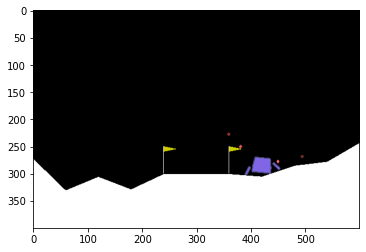

In [ ]:
env.reset()

img = plt.imshow(env.render(mode='rgb_array'))
# env.render() 視覺化呈現，它只會回應出呼叫那一刻的畫面給你，要它持續出現，需要寫個迴圈。

done = False
while not done:
    action = env.action_space.sample()
    observation, reward, done, _ = env.step(action)

    img.set_data(env.render(mode='rgb_array'))
    # img.set_data(self, A) => set the image array.

    display.display(plt.gcf())
    # display(obj, **kwargs) => Make a new display with my id, updating existing instances.
    # plt.gcf() => 得到當前的 figure

    display.clear_output(wait=True) # 在同個視窗顯示結果

## Policy Gradient

現在來搭建一個簡單的 policy network。
我們預設模型的輸入是 8-dim 的 observation，輸出則是離散的四個動作之一：

In [ ]:
class PolicyGradientNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(8, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 4)

    def forward(self, state):
        hid = torch.tanh(self.fc1(state))
        hid = torch.tanh(self.fc2(hid))
        return F.softmax(self.fc3(hid), dim=-1)

再來，搭建一個簡單的 agent，並搭配上方的 policy network 來採取行動。
這個 agent 能做到以下幾件事：
- `learn()`：從記下來的 log probabilities 及 rewards 來更新 policy network。
- `sample()`：從 environment 得到 observation 之後，利用 policy network 得出應該採取的行動。
而此函式除了回傳抽樣出來的 action，也會回傳此次抽樣的 log probabilities。

In [ ]:
class PolicyGradientAgent():

    def __init__(self, network):
        self.network = network
        # self.optimizer = optim.SGD(self.network.parameters(), lr=0.001)
        self.optimizer = optim.SGD(self.network.parameters(), lr=0.001, momentum=0.9)

    def learn(self, log_probs, rewards):
        loss = (-log_probs * rewards).sum()

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def sample(self, state):
        action_prob = self.network(torch.FloatTensor(state))
        action_dist = Categorical(action_prob) # orch.distributions.Categorical() => 功能：根據概率分佈來產生 sample，產生的 sample 是輸入 tensor 的 index
        action = action_dist.sample()
        log_prob = action_dist.log_prob(action) # use log_prob to construct an equivalent loss function
        return action.item(), log_prob

最後，建立一個 network 和 agent，就可以開始進行訓練了。

In [ ]:
network = PolicyGradientNetwork()
agent = PolicyGradientAgent(network)
print(agent.network)
print(agent.optimizer)

PolicyGradientNetwork(
  (fc1): Linear(in_features=8, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=4, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)


## 訓練 Agent

現在我們開始訓練 agent。
透過讓 agent 和 environment 互動，我們記住每一組對應的 log probabilities 及 reward，並在成功登陸或者不幸墜毀後，回放這些「記憶」來訓練 policy network。

In [ ]:
# TA 可以參考用
# agent.network.train()  # 訓練前，先確保 network 處在 training 模式
# EPISODE_PER_BATCH = 5  # 每蒐集 5 個 episodes 更新一次 agent
# NUM_BATCH = 400        # 總共更新 400 次

# Mine
agent.network.train()  # 訓練前，先確保 network 處在 training 模式
EPISODE_PER_BATCH = 5  # 每蒐集 5 個 episodes 更新一次 agent
NUM_BATCH = 250        # 總共更新 250 次
gamma = 0.99           # 設定 gamma
best = 0

avg_total_rewards, avg_final_rewards = [], []

prg_bar = tqdm_notebook(range(NUM_BATCH))

# tqdm 可以顯示迴圈的進度條的庫，再也不用擔心不知道程式跑到哪裡還要跑多久了，tqdm()可以直接包裹iterable的物件
# 如果要在Jupyter Notebook上面使用，那麼要把tqdm換成tqdm_notebook，trange換成tnrange
for batch in prg_bar: # 總共更新 "NUM_BATCH" 次

    log_probs, rewards = [], []
    total_rewards, final_rewards = [], []

    # 蒐集訓練資料
    for episode in range(EPISODE_PER_BATCH): # 每蒐集 "EPISODE_PER_BATCH" 個 episodes 更新一次 agent
        
        state = env.reset()
        total_reward, total_step = 0, 0
        tip_2_temp = []
        tip_2 = []

        while True:

            action, log_prob = agent.sample(state) # sample which action
            next_state, reward, done, _ = env.step(action) # return: observation/state, reward, 完成與否, 其餘資訊

            log_probs.append(log_prob)
            state = next_state
            total_reward += reward
            tip_2_temp.append(reward) # 得到所有的 reward
            total_step += 1

            if done:
                for i in range(len(tip_2_temp)):
                    tip_2.append((gamma**i)*sum(tip_2_temp[i:])) # implement tip_2

                final_rewards.append(reward)
                total_rewards.append(total_reward)
                # rewards.append(np.full(total_step, total_reward))  # 設定同一個 episode 每個 action 的 reward 都是 total reward (same rewards)
                # 產生 dim = 1*total_step， value = total_reward 之 array

                tip_2 = np.array(tip_2)
                # rewards.append(tip_2 - np.mean(tip_2))  # implement tip_1 + tip_2
                rewards.append(tip_2 - (-100))  # implement tip_1 + tip_2

                # numpy.full => numpy.full(shape, fill_value, dtype=None, order='C')
                # 返回一個根據指定shape和type，並用fill_value填充的新數組。
                # 參數:
                # shape：整數或整數序列新數組的形態，單個值代表一維，參數傳元組，元組中元素個數就代表是幾維，例如， (2, 3) or 2.
                # fill_value： 標量(無向量)，填充數組的值
                # dtype：數據類型，可選，默認值為None，查看要填充數組的值數據類型：np.array(fill_value).dtype。
                # order：{‘C’, ‘F’}, 可選，是否在內存中以行為主（C風格）或列為主（Fortran風格）連續（行或列)順序存儲多維數據。
                # 返回值:
                # 返回值類型 : ndarray(ndarray是N維數組對象)，根據指定的參數生成的數組

                break

    # 紀錄訓練過程
    avg_total_reward = sum(total_rewards) / len(total_rewards)
    avg_final_reward = sum(final_rewards) / len(final_rewards)
    if(avg_total_reward > best):
        torch.save(agent.network.state_dict(), './best.pth')
        print('save model')
        best = avg_total_reward
    avg_total_rewards.append(avg_total_reward)
    avg_final_rewards.append(avg_final_reward)
    prg_bar.set_description(f"Total: {avg_total_reward: 4.1f}, Final: {avg_final_reward: 4.1f}") # 顯示進度

    # 更新網路
    rewards = np.concatenate(rewards, axis=0)
    rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-9)  # 將 reward 正規標準化，加一個小項避免除以 0
    agent.learn(torch.stack(log_probs), torch.from_numpy(rewards)) # caculate loss

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


save model
save model
save model



### 訓練結果

訓練過程中，我們持續記下了 `avg_total_reward`，這個數值代表的是：每次更新 policy network 前，我們讓 agent 玩數個回合（episodes），而這些回合的平均 total rewards 為何。
理論上，若是 agent 一直在進步，則所得到的 `avg_total_reward` 也會持續上升，直至 250 上下。
若將其畫出來則結果如下：

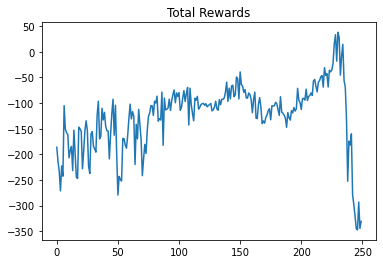

In [ ]:
plt.plot(avg_total_rewards)
plt.title("Total Rewards")
plt.show()

另外，`avg_final_reward` 代表的是多個回合的平均 final rewards，而 final reward 即是 agent 在單一回合中拿到的最後一個 reward。
如果同學們還記得環境給予登月小艇 reward 的方式，便會知道，不論**回合的最後**小艇是不幸墜毀、飛出畫面、或是靜止在地面上，都會受到額外地獎勵或處罰。
也因此，final reward 可被用來觀察 agent 的「著地」是否順利等資訊。

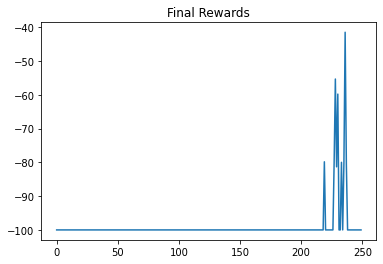

In [ ]:
plt.plot(avg_final_rewards)
plt.title("Final Rewards")
plt.show()

save model

In [ ]:
torch.save(agent.network.state_dict(), folder_path + 'agent_1_reward_-100_momentum09.pth')

## 測試

In [ ]:
# TA
# load model
network = PolicyGradientNetwork()
agent = PolicyGradientAgent(network)
agent.network.load_state_dict(torch.load(folder_path + 'agent_1_reward_-100_momentum09.pth'))
# agent.network.load_state_dict(torch.load('best.pth'))

# set eval mode
agent.network.eval()  # 測試前先將 network 切換為 evaluation 模式

state = env.reset()

img = plt.imshow(env.render(mode='rgb_array'))

total_reward = 0
step = 0

done = False
while not done:
    action, _ = agent.sample(state)
    state, reward, done, _ = env.step(action)

    total_reward += reward

    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)
    step += 1

In [ ]:
print(total_reward)

179.69889816666117


In [ ]:
# Mean10
# 測試 10 次取平均得到 final reward

import time
# load model
testing_time = time.time()
network = PolicyGradientNetwork()
agent = PolicyGradientAgent(network)
agent.network.load_state_dict(torch.load(folder_path + 'agent_1_reward_-100_momentum09.pth'))

# set eval mode
agent.network.eval()  # 測試前先將 network 切換為 evaluation 模式

state = env.reset()

img = plt.imshow(env.render(mode='rgb_array'))

total_reward = 0
total_reward_Mean10 = []

done = False
for count in range(10):

  # set eval mode
  agent.network.eval()  # 測試前先將 network 切換為 evaluation 模式
  state = env.reset()
  img = plt.imshow(env.render(mode='rgb_array'))
  total_reward = 0
  done = False

  while not done:
      action, _ = agent.sample(state)
      state, reward, done, _ = env.step(action)

      total_reward += reward

      img.set_data(env.render(mode='rgb_array'))
      display.display(plt.gcf())
      display.clear_output(wait=True)
  total_reward_Mean10.append(total_reward)
  print('finish episode ' + str(count + 1))

print('testing time =', time.time() - testing_time, 'sec')

算出 total_reward_Mean10 平均值

In [ ]:
total_reward_Mean10
total_reward_Mean10_arr = np.array(total_reward_Mean10)
print(total_reward_Mean10_arr)
print(np.mean(total_reward_Mean10_arr))

[-163.31577309 -116.87938097  -68.96306949 -205.16841001 -146.61124547
  -89.49512817 -218.22392783 -132.35524655  -74.26243829  -90.91429855]
-130.61889184120042


## 參考資料

以下是一些有用的參考資料。
建議同學們實做前，可以先參考第一則連結的上課影片。
在影片的最後有提到兩個有用的 Tips，這對於本次作業的實做非常有幫助。

- [DRL Lecture 1: Policy Gradient (Review)](https://youtu.be/z95ZYgPgXOY)
- [ML Lecture 23-3: Reinforcement Learning (including Q-learning) start at 30:00](https://youtu.be/2-JNBzCq77c?t=1800)
- [Lecture 7: Policy Gradient, David Silver](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching_files/pg.pdf)
